# Fitting a double-Wilson model to a pair of datasets

# Introduction

In this notebook, we fit the double-Wilson (DW) model to real data that has been preprocessed in **notebook 1**. After loading in the data and inspecting a few properties,
-  in the section **Calculating effective Rice dist parameters per reflection**, we fit a resolution-dependent $r$ to the data. The $r$ depends on both the $a$ and $b$ parameters in **notebook 2b**, as well as resolution-dependent measurement error. 
- in the section **Inspection of the $|E_1|$ and $|E_2|$ distributions**, we check the quality of the DW model fit by visually comparing histograms of the structure factor amplitudes (SFAs) $|E_1|$ and $|E_2|$ to the DW distribution. 
- in the section **Let's take a look at phases!**, we check that the phases follow the expected von Mises distribution (Bricogne, Methods in Enzymology (1997), eq. 1.10).

As before, we will use $r$ or $r_{DW}$ for the double-Wilson correlation parameter. 

## Importing modules

In [3]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy   as np
import pandas as pd

In [4]:
import reciprocalspaceship as rs
import gemmi
from scipy.optimize  import least_squares, minimize
from scipy.stats     import rice, foldnorm, vonmises, linregress, pearsonr
from dw_tools        import fitting_dw, modify_ds

In [69]:
%autosave 300
# !cat /proc/meminfo | grep Mem
%load_ext autoreload
%autoreload 2
rs.__version__

new_rc_params = {
    'text.usetex': False,
    "svg.fonttype": 'none',
    "font.size" : 12,
}

plt.rcParams.update(new_rc_params)
plt.rcParams.update({'figure.figsize':(5,3.5)})

Autosaving every 300 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading data

In [24]:
# path="double_wilson_data\\" # Windows
# fig_dir = "results_figs\\"
path="double_wilson_data/"    # Unix
fig_dir = "results_figs/"
data_set_pairs = {0:("5kvx_phases", "5kw3_phases"),\
                  1:("3pyp_phases", "1nwz_phases"),\
                  2:("4kjk_phases", "4kjj_phases", "4pst_phases", "4pss_phases"),\
                  3:("NECAT_PTP1B_RT_SAD/7rin_phases", "NECAT_PTP1B_RT_SAD/7mm1_phases"),\
                  4:("4eul_phases","2y0g_phases")}

example=3 
ix1 = 0
ix2 = 1
mtz1 = data_set_pairs[example][ix1] # omit .mtz
mtz2 = data_set_pairs[example][ix2]
ds1 = rs.read_mtz(path + mtz1 + "_scaled.mtz")
ds2 = rs.read_mtz(path + mtz2 + "_scaled.mtz")

In [25]:
ds1_2 = ds1.merge(ds2, left_index=True, right_index=True, suffixes=("_1", "_2"))
ds1_2.label_centrics(inplace=True)
ds1_2.compute_multiplicity(inplace=True)
ds1_2, bin_labels = ds1_2.assign_resolution_bins(bins=20, inplace=True, return_labels=True);
# ds1_2.info()

EP1_label = "EP_1_knn_1"
EP2_label = "EP_1_knn_2"
dHKL_label = "dHKL_1"
dHKL_bin_label = "bin"

### Initial inspection: average error versus resolution
Remember, we are looking at normalized structure factor amplitudes $E$ with errors `SIGEP` or $\sigma_E$!

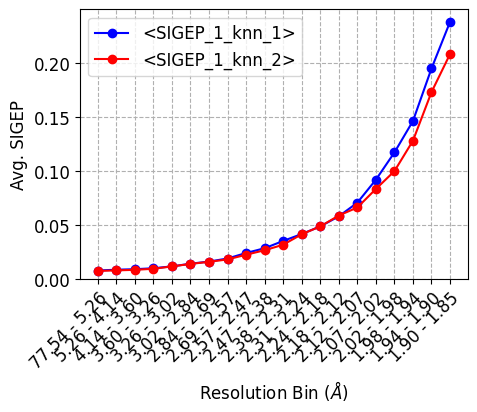

In [26]:
result = ds1_2.groupby(dHKL_bin_label)["SIG" + EP1_label].mean()
plt.plot(result.to_numpy(),'bo-', label="<SIG" + EP1_label + ">")
result = ds1_2.groupby(dHKL_bin_label)["SIG" + EP2_label].mean()
plt.plot(result.to_numpy(),'ro-', label="<SIG" + EP2_label + ">")
plt.xticks(result.index, bin_labels, rotation=45, ha="right", rotation_mode="anchor")
plt.xlabel(r"Resolution Bin ($\AA$)")
plt.ylabel("Avg. SIGEP")
plt.grid(linestyle='--')
plt.ylim([0,plt.ylim()[1]]); plt.legend(); plt.show()

Optionally, apply a resolution cutoff.

In [27]:
if False:
    modify_ds.ds_high_res_cut(ds1_2, rescut=2, inplace=True)

Like in **notebook 2b**, we are estimating effective _a_ and _b_ to best capture the correlations between the datasets. This estimate corrects for measurement error to estimate the correlation of the underlying "true" structure factor amplitudes.

In [28]:
(a,b) = fitting_dw.fit_ab(ds1_2,labels=[EP1_label,EP2_label],\
                          dHKL_label=dHKL_label, dHKL_bin_label=dHKL_bin_label)
print(f"a: {a:.4}")
print(f"b: {b:.4}")

`xtol` termination condition is satisfied.
Function evaluations 15, initial cost 2.1110e+00, final cost 6.5367e-02, first-order optimality 1.76e-06.
a: 0.8486
b: 0.2372


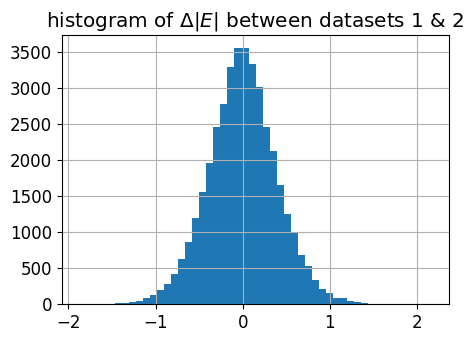

In [29]:
plt.hist(ds1_2[EP1_label]- ds1_2[EP2_label],50)
plt.title(r"histogram of $\Delta|E|$ between datasets 1 & 2")
plt.grid()
plt.show()

This should look approximately normal, as ascertained in **notebook 6**.

# Calculating effective Rice distribution parameters per reflection
In **notebook 2b**, we made an argument about the relationship between the observed and true correlation of two noisy datsets. Here, we make a similar argument about the expected correlation of a noisy observed dataset to the true amplitudes of a second dataset:

Consider two data sets of normalized structure factor amplitudes, $\{x\}$ and $\{x+\epsilon+\eta\}$, with the first data set ideal, $\epsilon$ the fixed, true differences between the data sets and $\eta$ the measurement errors. In this case, $\textrm{Cov}(x,x+\epsilon)$ is given by the double-Wilson distribution, as is $\sigma^2_{x}$. Once we've estimated $a$ and $b$ above such that $r(s)=a\cdot e^{-b s^2}$, we can calculate what value we should use to constrain a prior distribution for another data set by taking into account that our estimates are tainted by measurement error. 

To begin, we'll use the approximate relationship $\rho(|E_1|,|E_2|)=r_{DW}^2$ and the relationship

$\rho^{-2}_{obs}=\rho^{-2}_{DW} +\frac{\sigma^2_{\eta}}{\sigma^2_{x}}$,

with $\sigma_x$ the standard deviation of the Wilson distribution and different between centric and acentric reflections. This equation follows from:

$\rho(x,x+\varepsilon+\eta) = \frac{\sigma_x}{\sqrt{\sigma^2_x+\sigma^2_{\epsilon}+\sigma^2_{\eta}}}$
and $\rho_{DW}=\rho(x,x+\varepsilon)=\frac{\sigma_x}{\sqrt{\sigma^2_x+\sigma^2_{\epsilon}}}$

Now,

$r_{eff}\approx\sqrt{\rho_{obs}}$   and   $\rho_{obs}=1/\sqrt{\rho^{-2}_{DW} +\frac{\sigma^2_{\eta}}{\sigma^2_{x}}}$   and   $\rho_{DW}\approx r^2 = a^2 e^{-2bs^2}$ and $s=1/d_{HKL}$.

This has been implemented in `dw_tools/fitting_dw.py`:

In [30]:
fitting_dw.eff_r_dw_per_hkl(ds1_2,a,b,label=EP1_label, dHKL_label=dHKL_label, inplace=True);
fitting_dw.eff_r_dw_per_hkl(ds1_2,a,b,label=EP2_label, dHKL_label=dHKL_label, inplace=True);

In [31]:
# ds1_2.info()
ds1_2.to_pickle(path + "_with_rDW.pkl")

For completeness, a scatter plot of the normalized structure factor amplitudes of the two datasets.

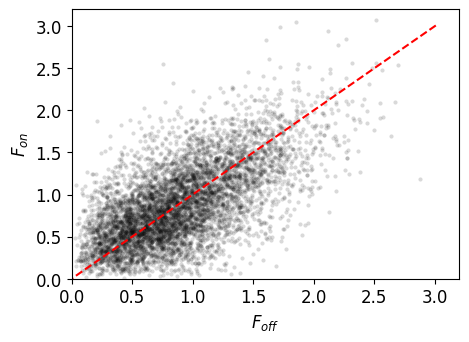

In [32]:
subset = ds1_2[[EP1_label, EP2_label]].sample(6000).to_numpy()
plt.plot(subset[:,0], subset[:,1],'k.',alpha=0.15,markeredgewidth=0)
xl=np.array(plt.xlim())
plt.plot(xl,xl,'r--')
plt.xlim((0,3.2)); plt.ylim((0,3.2))
plt.xlabel(r'$F_{off}$')
plt.ylabel(r'$F_{on}$')
plt.savefig(fig_dir + \
            os.path.basename(data_set_pairs[example][ix1]) + "_" + \
            os.path.basename(data_set_pairs[example][ix2]) + "_amplitude_scatter.svg")
plt.show()

# Inspection of the $|E_1|$ and $|E_2|$ distributions

## Binning by $|E_1|$
We compute the means per bin for $|E_1|$, determined separately for acentrics and centrics.
We will calculate the conditional distributions of $|E_2|$ per bin of $|E_1|$. Then, we'll set bin labels for both centrics and acentrics here:

In [33]:
nbin=25
cdf_bins = np.linspace(0,100,nbin+1)

ds1_2_centric  = (ds1_2["CENTRIC"].to_numpy()==True)
ds1_2_acentric = (ds1_2["CENTRIC"].to_numpy()==False)

ep1_bins          = np.percentile(ds1_2.loc[ds1_2_acentric, EP1_label], cdf_bins)
ep1_bins[-1]      = ep1_bins[-1]+1e-6                # to avoid omitting the largest data point
ep1_dig           = np.digitize(ds1_2.loc[  ds1_2_acentric, EP1_label], ep1_bins) # note that we're creating bin labels for all reflections, acentric or not

ep1_cent_bins     = np.percentile(ds1_2.loc[ds1_2_centric,  EP1_label], cdf_bins)
ep1_cent_bins[-1] = ep1_cent_bins[-1]+1e-6
ep1_cent_dig      = np.digitize(ds1_2.loc[  ds1_2_centric,  EP1_label], ep1_cent_bins) # note that we're creating bin labels for all reflections, acentric or not

ds1_2.loc[ds1_2_acentric, "EP_1_bin"] = ep1_dig.flatten()
ds1_2.loc[ds1_2_centric,  "EP_1_bin"] = ep1_cent_dig.flatten()

In [34]:
print(ep1_bins[0])
print(ep1_bins[1])
print(ep1_bins[12])
print(ep1_bins[13])
print(ep1_bins[22])
print(ep1_bins[23])

0.01047553401440382
0.23714837312698364
0.8194258213043213
0.8648473811149597
1.4468518590927126
1.5747698974609374


Some inspection of the created bins:

Number of reflections per bin (acentric):
{1.0: 1473, 2.0: 1472, 3.0: 1472, 4.0: 1473, 5.0: 1472, 6.0: 1472, 7.0: 1473, 8.0: 1472, 9.0: 1472, 10.0: 1473, 11.0: 1472, 12.0: 1472, 13.0: 1473, 14.0: 1472, 15.0: 1472, 16.0: 1473, 17.0: 1472, 18.0: 1472, 19.0: 1473, 20.0: 1472, 21.0: 1472, 22.0: 1473, 23.0: 1472, 24.0: 1472, 25.0: 1473}

Number of reflections per bin (centric):
{1.0: 132, 2.0: 131, 3.0: 131, 4.0: 131, 5.0: 131, 6.0: 131, 7.0: 132, 8.0: 131, 9.0: 131, 10.0: 131, 11.0: 131, 12.0: 131, 13.0: 132, 14.0: 131, 15.0: 131, 16.0: 131, 17.0: 131, 18.0: 131, 19.0: 132, 20.0: 131, 21.0: 131, 22.0: 131, 23.0: 131, 24.0: 131, 25.0: 132}


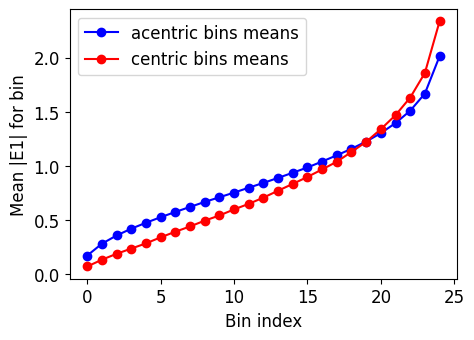

In [35]:
# For acentrics:
unique, counts = np.unique(ds1_2.loc[ds1_2_acentric, "EP_1_bin"], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin (acentric):"); print(temp)
print()

# for centrics
unique, counts = np.unique(ds1_2.loc[ds1_2_centric, "EP_1_bin"], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin (centric):");  print(temp)

bin_means_acentric = ds1_2[ds1_2_acentric].groupby("EP_1_bin")[EP1_label].mean()
bin_means_centric  = ds1_2[ds1_2_centric ].groupby("EP_1_bin")[EP1_label].mean()
plt.plot(bin_means_acentric.to_numpy(),'bo-',label="acentric bins means")
plt.plot(bin_means_centric.to_numpy(), 'ro-',label="centric bins means")
plt.xlabel("Bin index"); plt.ylabel("Mean |E1| for bin")
plt.legend(); plt.show()

## Conditional distribution for acentrics. Histograms of $|E_2|$ per bin of $|E_1|$
**Note**: In this section, we neglect the dependence of $r$ on resolution.

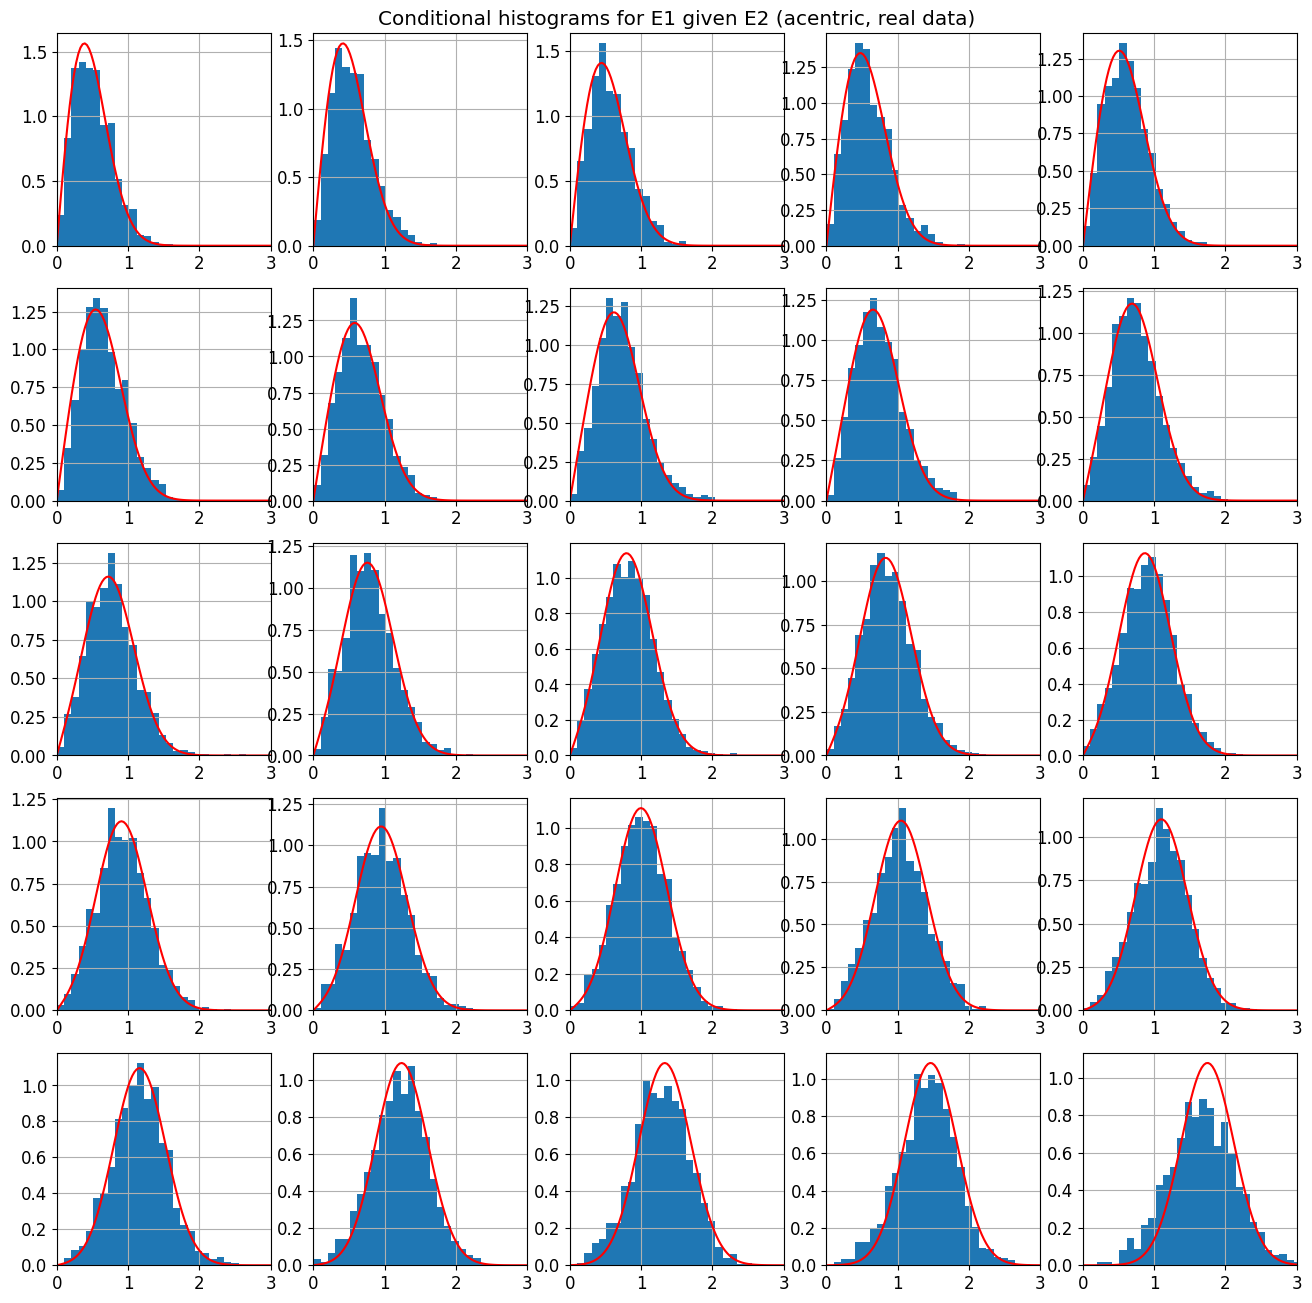

In [36]:
plt.figure(figsize=(16,16))
x=np.linspace(0,3,100)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    r = np.amin([a,0.98])          # a guess of the corr coef between data sets
    r1  = r*bin_means_acentric[i]  # conditional exp value of E1 given E2
    cond_var = 0.5*(1-r**2)        # conditional variance  of E1 given E2
#    
    plt.hist(ds1_2.loc[(ds1_2["EP_1_bin"]==i) & ds1_2_acentric, EP2_label],np.linspace(0,5,50),density=True)
    plt.plot(x, rice.pdf(x, r1/np.sqrt(cond_var), scale=np.sqrt(cond_var)),'r-')
    xl=[0,3] 
    plt.xlim(xl); plt.grid()

plt.subplot(5,5,3)
plt.title("Conditional histograms for E1 given E2 (acentric, real data)")
plt.savefig(fig_dir + \
            os.path.basename(data_set_pairs[example][ix1]) + "_" + \
            os.path.basename(data_set_pairs[example][ix2]) + "_acentric_amplitude_cond_hists.svg")
plt.show()

The conditional distribution for acentrics fits the real data pretty well (remember that we are neglecting that $r$ depends on resolution). Let's do a closer inspection of a few $|E_1|$ bins, as we did in **notebook 2a**. 

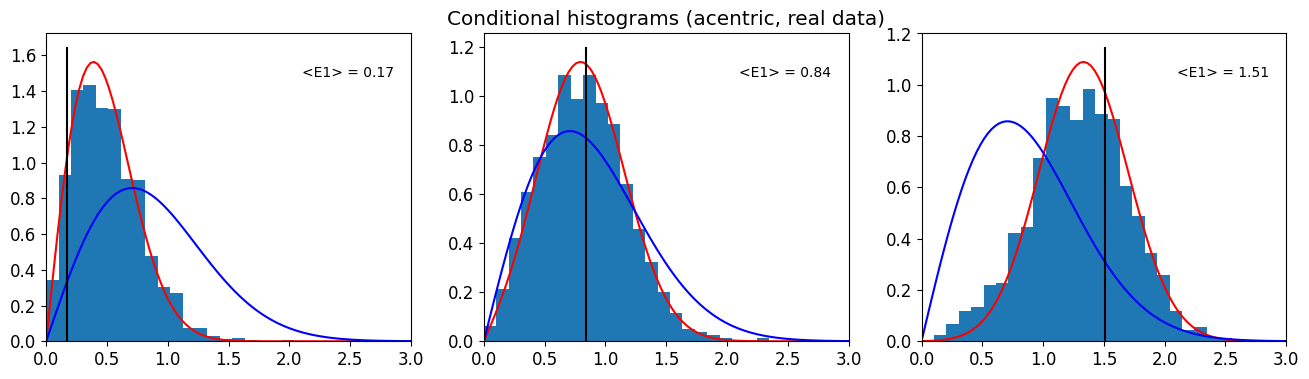

In [70]:
plt.figure(figsize=(16,4))
x=np.linspace(0,3,100)
counter = 0
for i in [1, 13, 23]:
    counter += 1             # for illustration purposes.
    plt.subplot(1,3,counter) # for illustration purposes.
    r_DW = np.amin([a,0.98])
    r1 = r_DW*bin_means_acentric[i]     # conditional exp value
    cond_var = 0.5*(1-r_DW**2) # conditional var for acentrics
    
    plt.hist(ds1_2.loc[ds1_2["EP_1_bin"]==i,EP2_label],np.linspace(0,5,50),density=True)
    plt.plot(x, rice.pdf(x, r1/np.sqrt(cond_var),scale=np.sqrt(cond_var)),'r-')
    plt.plot(x, rice.pdf(x, 0,scale=np.sqrt(0.5)),'b-')
    yl=plt.ylim()

#    to illustrate the idea of Rice interpolating between Wilson and delta function:
    plt.plot(bin_means_acentric[i]*np.asarray([1, 1]),yl,'k-')
    xl=[0,3] #plt.xlim()
    plt.text(2.1,0.9*yl[1],f"<E1> = {bin_means_acentric[i]:.2f}",size=10)
    plt.xlim(xl)
    if counter == 2:
        plt.title("Conditional histograms (acentric, real data)")
plt.savefig(fig_dir+os.path.basename(data_set_pairs[example][ix1]) + "_" + \
            os.path.basename(data_set_pairs[example][ix2]) + "_acentric.svg")
plt.show()
# Basic check:
#    plt.plot(np.sqrt((1-rho**2)+rho**2 * bin_means[i]**2), np.sqrt(np.mean(ds_test["EP_2"][ds_test["EP_1_bin"]==i]**2)), 'bo')

## Conditional distribution for centrics. Histograms of $|E_2|$ per bin of $|E_1|$

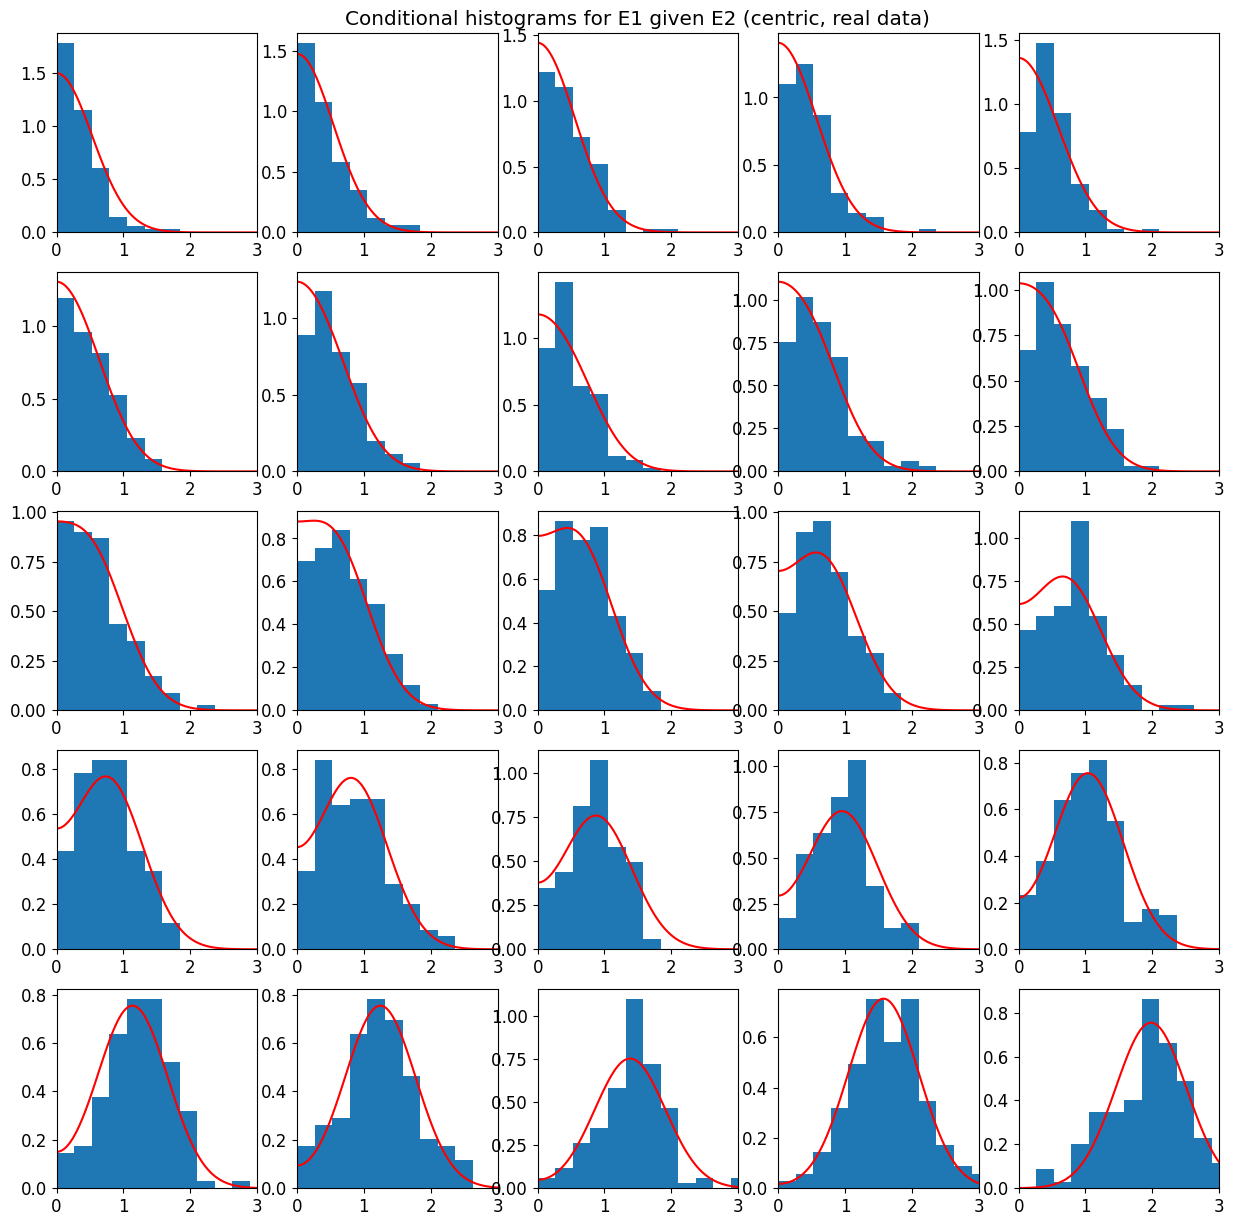

In [38]:
plt.figure(figsize=(15,15))
x=np.linspace(0,3,100)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    r = np.amin([a,0.98])          # a guess of the corr coef between data sets
    r1  = r*bin_means_centric[i]   # conditional exp value of E1 given E2
    cond_var = (1-r**2)            # conditional variance  of E1 given E2
#    
    plt.hist(ds1_2.loc[(ds1_2["EP_1_bin"]==i) & ds1_2_centric,EP2_label],np.linspace(0,5,20),density=True)
    plt.plot(x, foldnorm.pdf(x, r1/np.sqrt(cond_var), scale=np.sqrt(cond_var)),'r-')
    xl=[0,3] 
    plt.xlim(xl)

plt.subplot(5,5,3)
plt.title("Conditional histograms for E1 given E2 (centric, real data)")
plt.savefig(fig_dir + \
            os.path.basename(data_set_pairs[example][ix1]) + "_" + \
            os.path.basename(data_set_pairs[example][ix2]) + "_centric_amplitude_cond_histograms.svg")
plt.show()

The conditional distribution for centrics fits the real data pretty well. 

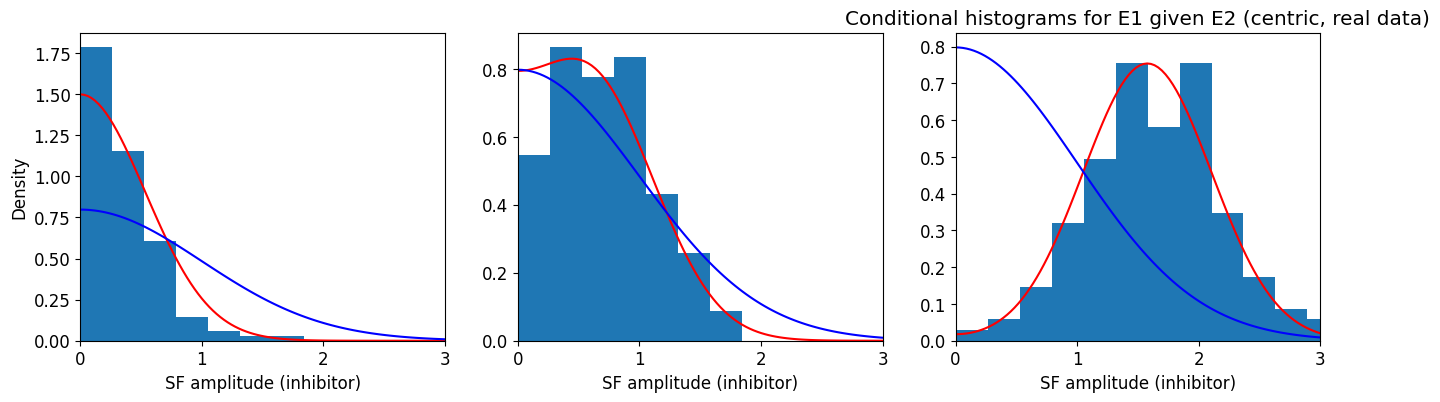

In [71]:
counter = 0
plt.figure(figsize=(16,4))
x=np.linspace(0,3,100)
for i in [1,13,24]:
    counter += 1             # for illustration purposes.
    plt.subplot(1,3,counter) # for illustration purposes.
    r = np.amin([a,0.98])          # a guess of the corr coef between data sets
    r1  = r*bin_means_centric[i]   # conditional exp value of E1 given E2
    cond_var = (1-r**2)            # conditional variance  of E1 given E2
#    
    plt.hist(ds1_2.loc[(ds1_2["EP_1_bin"]==i) & ds1_2_centric,EP2_label],np.linspace(0,5,20),density=True)
    plt.plot(x, foldnorm.pdf(x, r1/np.sqrt(cond_var), scale=np.sqrt(cond_var)),'r-')
    plt.plot(x, foldnorm.pdf(x, 0,scale=1),'b-')
    xl=[0,3] 
    plt.xlim(xl)
    plt.xticks([0,1,2,3])
    plt.xlabel("SF amplitude (inhibitor)")
    if i==1:
        plt.ylabel("Density")

plt.title("Conditional histograms for E1 given E2 (centric, real data)")
plt.savefig(fig_dir + \
            os.path.basename(data_set_pairs[example][ix1]) + "_" + \
            os.path.basename(data_set_pairs[example][ix2]) + "_centric_small.svg")
plt.show()

# Let's take a look at phases!
Ultimately, this work should set us up to create full conditional distributions of one dataset given another, and to propagate these ideas to refinement. For example, we can obtain the probabilities of phases of one dataset conditioned on the phases of another. 

NOTE: whether or not the phases closely agree in the plots below depends CRITICALLY on whether the source of these phases had a consistent choice of unit cell origin.

In [ ]:
# ALl "phase keys":
ds1_2.filter(regex="PH").info()

In [ ]:
plt.plot(ds1_2.loc[ds1_2_centric==False,"PHIC_1"].to_numpy(),\
         ds1_2.loc[ds1_2_centric==False,"PHIC_2"].to_numpy(),'bo',alpha=0.01)
plt.xlabel("PHIC_1 (deg)")
plt.ylabel("PHIC_2 (deg)")
plt.title("Phases for acentric reflections")

plt.savefig(fig_dir + \
            os.path.basename(data_set_pairs[example][ix1]) + "_" + \
            os.path.basename(data_set_pairs[example][ix2]) + "_acentric_phase_scatter.svg")
plt.show()

As described by (Bricogne, Methods in Enzymology, 1997: eq. 1.10), the conditional PDF for the phase difference between two similar structure is given by the Von Mises distribution. Because of the structure of the Von Mises distribution, this conditional probability is a function only of $|E_1| \times |E_2|$. We'll bin by that. For now, we'll only think about acentrics.

Specifically, the Von Mises distribution is given by:

$P\left( \Delta \varphi | |E_1|, |E_2| \right) = \frac{1}{2\pi I_0(z)}\exp\left( z \cos(\Delta \varphi)\right)$ 

with $z = \frac{2 |E_1|\cdot |E_2|}{(1-r^2)}$

which can also be derived by dividing eq. 14 of Bricogne (1997) for $P(R,\varphi | r)$ by $P(R | r)$. Noting that Bricogne's notation maps to ours as, $\rho=r_{DW}$, $R=|E_2|$ and $r=|E_1|$.

In [ ]:
ds1_2["DeltaPHIC"] = np.remainder((np.pi/180.0)*(ds1_2["PHIC_2"].to_numpy()-ds1_2["PHIC_1"].to_numpy()),2*np.pi)
ds1_2["cos(DeltaPHIC)"] = np.cos(ds1_2["DeltaPHIC"])

plt.hist(ds1_2.loc[ds1_2["CENTRIC"]==False, "DeltaPHIC"],50 )
plt.xlabel(r"$\Delta\phi$")
plt.ylabel('Count')
plt.show()

In [ ]:
cdf_bins = np.linspace(0,100,nbin+1)

ds1_2["EP1_EP2"]  = ds1_2[EP1_label] * ds1_2[EP2_label]                                 

# For acentrics:
ep12_bins       = np.percentile(ds1_2.loc[ds1_2_acentric, "EP1_EP2"], cdf_bins)
ep12_bins[-1]   = ep12_bins[-1]+1e-6                # to avoid omitting the largest data point
ep12_dig        = np.digitize(ds1_2.loc[  ds1_2_acentric, "EP1_EP2"], ep12_bins)
ds1_2.loc[ds1_2_acentric, "EP1_EP2_bin"] = ep12_dig.flatten()

unique, counts = np.unique(ds1_2.loc[ds1_2_acentric, "EP1_EP2_bin"], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin (acentric):")
print(temp)

bin_means_12_acentric = ds1_2[ds1_2_acentric].groupby("EP1_EP2_bin")["EP1_EP2"].mean()                                 

We again simplify to a single correlation coefficient over the resolution range.

In [ ]:
# for acentrics:
plt.figure(figsize=(15,15))
x = np.linspace(0,2*np.pi,50)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    r = np.amin([a,0.98])
    cond_var = 0.5*(1-r**2)          # conditional variance  of E1 given E2
#    
    plt.hist(ds1_2.loc[(ds1_2["EP_1_bin"]==i) & ds1_2_acentric, "DeltaPHIC"],np.linspace(0,2*np.pi,50),density=True)
    plt.plot(x, vonmises.pdf(x, bin_means_12_acentric[i]/cond_var),'r-')
plt.title(f"phase difference with {r:.3f} fit")

plt.savefig(fig_dir + \
            os.path.basename(data_set_pairs[example][ix1]) + "_" + \
            os.path.basename(data_set_pairs[example][ix2]) + "_acentric_phase_diff_histogram.svg")
plt.show()

The fit von Mises distribution agrees with the real data. 